In [46]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import hyperopt as hyp
from hyperopt.plotting import main_plot_history, main_plot_histogram
from pprint import pprint
from scipy.ndimage.filters import gaussian_filter1d
from utils.helper import Helper
import os
from matplotlib import cm
import matplotlib as mpl
import shutil
import matplotlib.patches as mpatches

from tensorflow.python.summary.summary_iterator import summary_iterator
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator

plt.style.use('ggplot')
SMALL_SIZE = 12
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [65]:
def normalize(X):
    min = X.min()
    max = X.max()
    
    return ((X - min)/ (max-min))

def view_params_w_acc(param, results, ax):
    param_values = []
    acc = []
    for result in results:
        acc.append(result['best_val_accuracy'])
        space = result['space']
        param_values.append(space[param])
    
    color = cm.plasma_r(normalize(np.array(acc)))
    ax.set_title(param)
    ax.set_yticks([])
    s =ax.scatter(param_values, acc, s=200, c=color)
    return s

def load_images(dir_path, H=128, W=128):
    files = os.listdir(dir_path)
    N = len(files)
    X = np.empty((N, H, W, 3))
    for i, file in tqdm(enumerate(files)):
        x = cv2.imread(dir_path + file)
        x = cv2.resize(x, (H,W))
        x = x/np.max(x)
        X[i] = x
    
    return X

def tb_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_data_from_tb(model_ids, tb_dir):
    tb_data = dict()
    tb_dirs = [os.path.join(tb_dir, id) for id in model_ids]
    keys = ['train', 'validation']
    for i, tb_dir in enumerate(tb_dirs):
        key_dict = dict()
        for key in keys:
            dir = os.path.join(tb_dir, key)
            tag_dict = dict()
            loss = []
            acc = []
            for filename in os.listdir(dir):
                if filename == 'plugins':
                    continue
                path = os.path.join(dir, filename)
                for event in tb_summary_iterator(path):
                    for v in event.summary.value:
                        if v.tag == 'epoch_loss':
                            loss.append(v.simple_value)
                            
                        elif v.tag == 'epoch_accuracy':
                            acc.append(v.simple_value)
                            
            tag_dict['loss'] = loss
            tag_dict['acc'] = acc
            key_dict[key] = tag_dict
            tb_data[model_ids[i]] = key_dict
    
    return tb_data

def plot_loss_acc_curve(tb_data, key, titles):
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(50,20))
    for model_id, ax, title in zip(tb_data, axes.flatten(), titles):
        
        train = tb_data[model_id]['train'][key] 
        val = tb_data[model_id]['validation'][key] 
        
        ax.set_title(title)
        ax.plot(train, label="training {}".format(key), linewidth=3, c="#1E88E5")
        ax.plot(val, label="validation {}".format(key), linewidth=3, c="#D81B60")
        ax.set_xlabel('epochs')
        ax.set_ylabel(key)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    
    return fig

def save_and_rename_models(srcs, dsts):
    
    for src, dst in zip(srcs, dsts):
        shutil.copy(src, dst)

In [3]:
tm_acc = []
spsm_acc = []

tm_trials = pickle.load(open("results_RT_ERP_10.pkl", "rb"))
spsm_trials = pickle.load(open("results_RT_50.pkl", "rb"))

spsm_acc = np.array(spsm_trials.losses())
tm_acc = np.array(tm_trials.losses())

spsm_acc = -spsm_acc[spsm_acc != None].astype(np.float)
tm_acc = -tm_acc[tm_acc != None].astype(np.float)

In [4]:
spsm_results = []
tm_results = []

h_spsm = Helper(None, None, "results/RT_50/")
h_tm = Helper(None, None, "results/ERP_RT_10/")

for spsm_dir, tm_dir in zip(os.listdir(h_spsm.results_directory), 
                            os.listdir(h_tm.results_directory)):
    json_spsm = h_spsm.load_json_result(spsm_dir)
    json_tm = h_tm.load_json_result(tm_dir)
    spsm_results.append(json_spsm)
    tm_results.append(json_tm)             

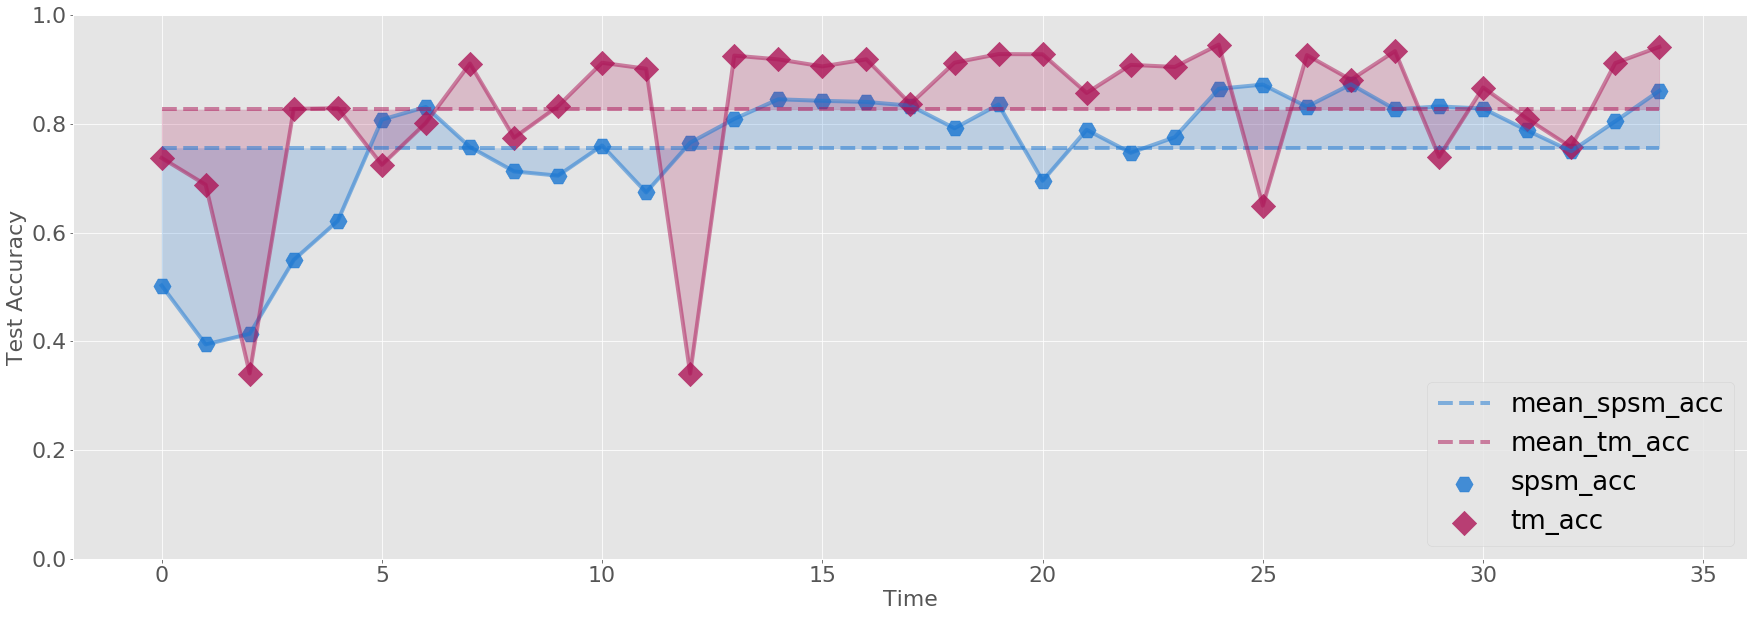

In [47]:
time = np.arange(0, len(spsm_acc))

fig = plt.figure(figsize=(30,10))

# plt.subplot(121)
plt.scatter(time, spsm_acc, c='#1976D2',s=300, marker="H", alpha=0.8, label='spsm_acc')
plt.plot(time, spsm_acc, color='#1976D2', linewidth=4, alpha=0.5)
plt.plot(time, len(spsm_acc) * [spsm_acc.mean()], '--', color='#1976D2', 
         linewidth=4, alpha=0.5, label='mean_spsm_acc')
plt.fill_between(time, spsm_acc, spsm_acc.mean(), color='#1976D2', alpha=0.2)
plt.xlabel("Time")
plt.ylabel("Test Accuracy")
plt.ylim([0,1])


# plt.subplot(122)
plt.scatter(time, tm_acc, c='#AD1457', s=300, marker="D", alpha=0.8, label='tm_acc')
plt.plot(tm_acc, c='#AD1457', linewidth=4, alpha=0.5)
plt.plot(time, len(tm_acc) * [tm_acc.mean()], '--', color='#AD1457', 
         linewidth=4, alpha=0.5, label='mean_tm_acc')
plt.fill_between(time, tm_acc, tm_acc.mean(), color='#AD1457', alpha=0.2)

plt.legend(loc='lower right')

plt.show()

#### SPSM Parameters during TPE optimization

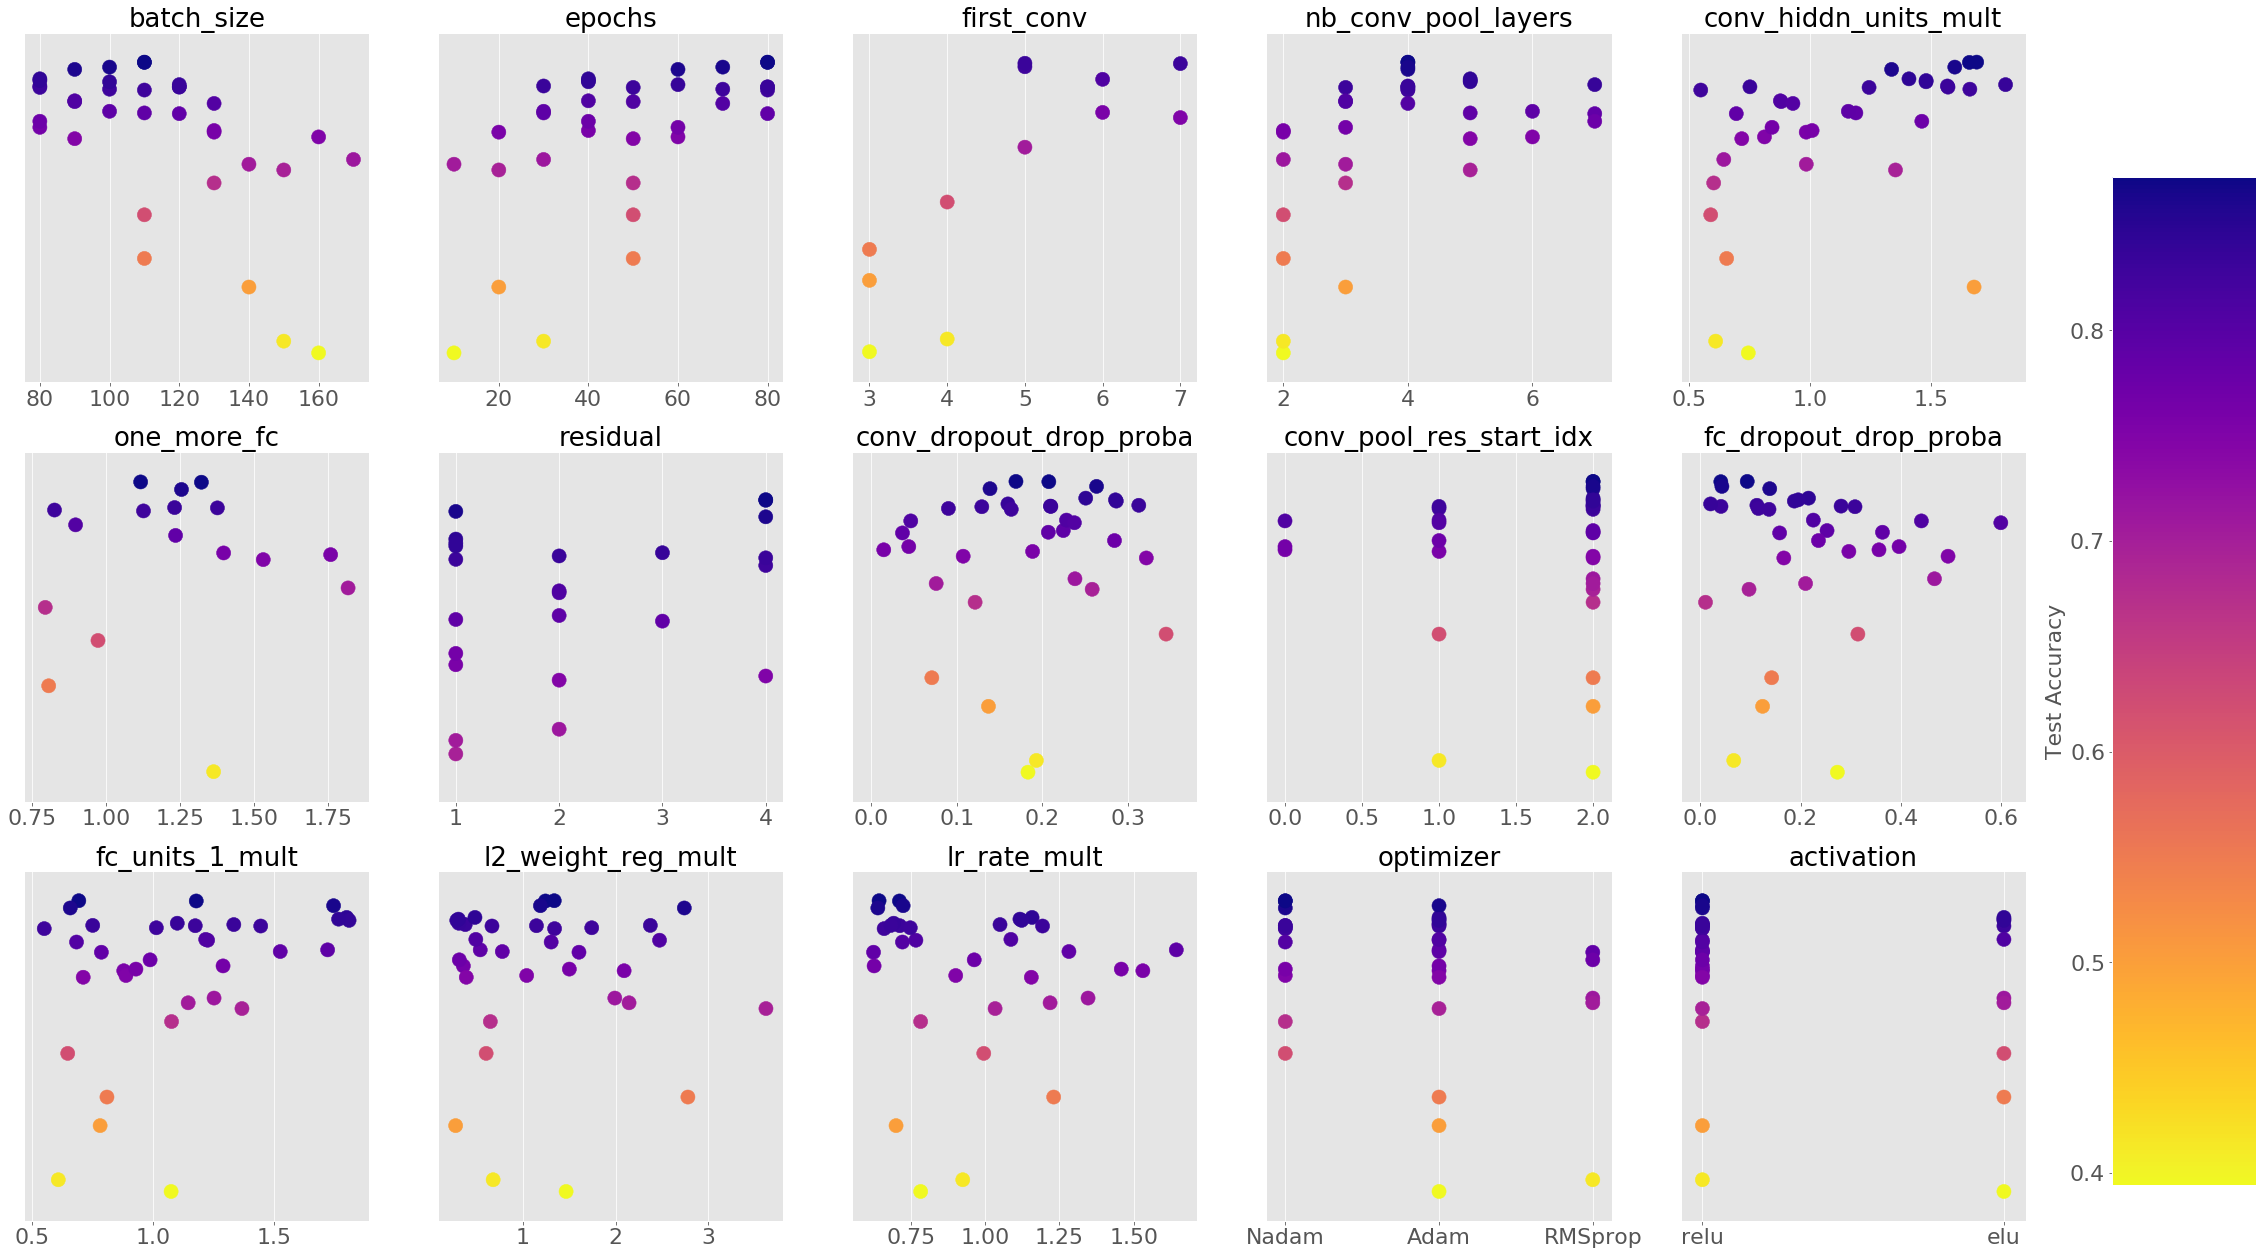

In [48]:
int_params_names_to_correlate = [
    'batch_size',
    'epochs',
    'first_conv',
    'nb_conv_pool_layers',
    'conv_hiddn_units_mult',
    'one_more_fc',
    'residual',
    'conv_dropout_drop_proba',
    'conv_pool_res_start_idx',
    'fc_dropout_drop_proba',
    'fc_units_1_mult',
    'l2_weight_reg_mult',
    'lr_rate_mult',
    'optimizer',
    'activation',
]

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(40,20))

axes = axes.flatten()
s = None
for ax, param in zip(axes, int_params_names_to_correlate):
    s = view_params_w_acc(param, spsm_results, ax)
    
    
fig.subplots_adjust(right=0.82, top=0.95)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

cmap = mpl.cm.plasma_r
norm = mpl.colors.Normalize(vmin=spsm_acc.min(), vmax=spsm_acc.max())

cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical', ticklocation='left')
cb1.set_label('Test Accuracy', fontdict={'size': 22})

###### TOP 10 SPSMs based on best val_accuracy

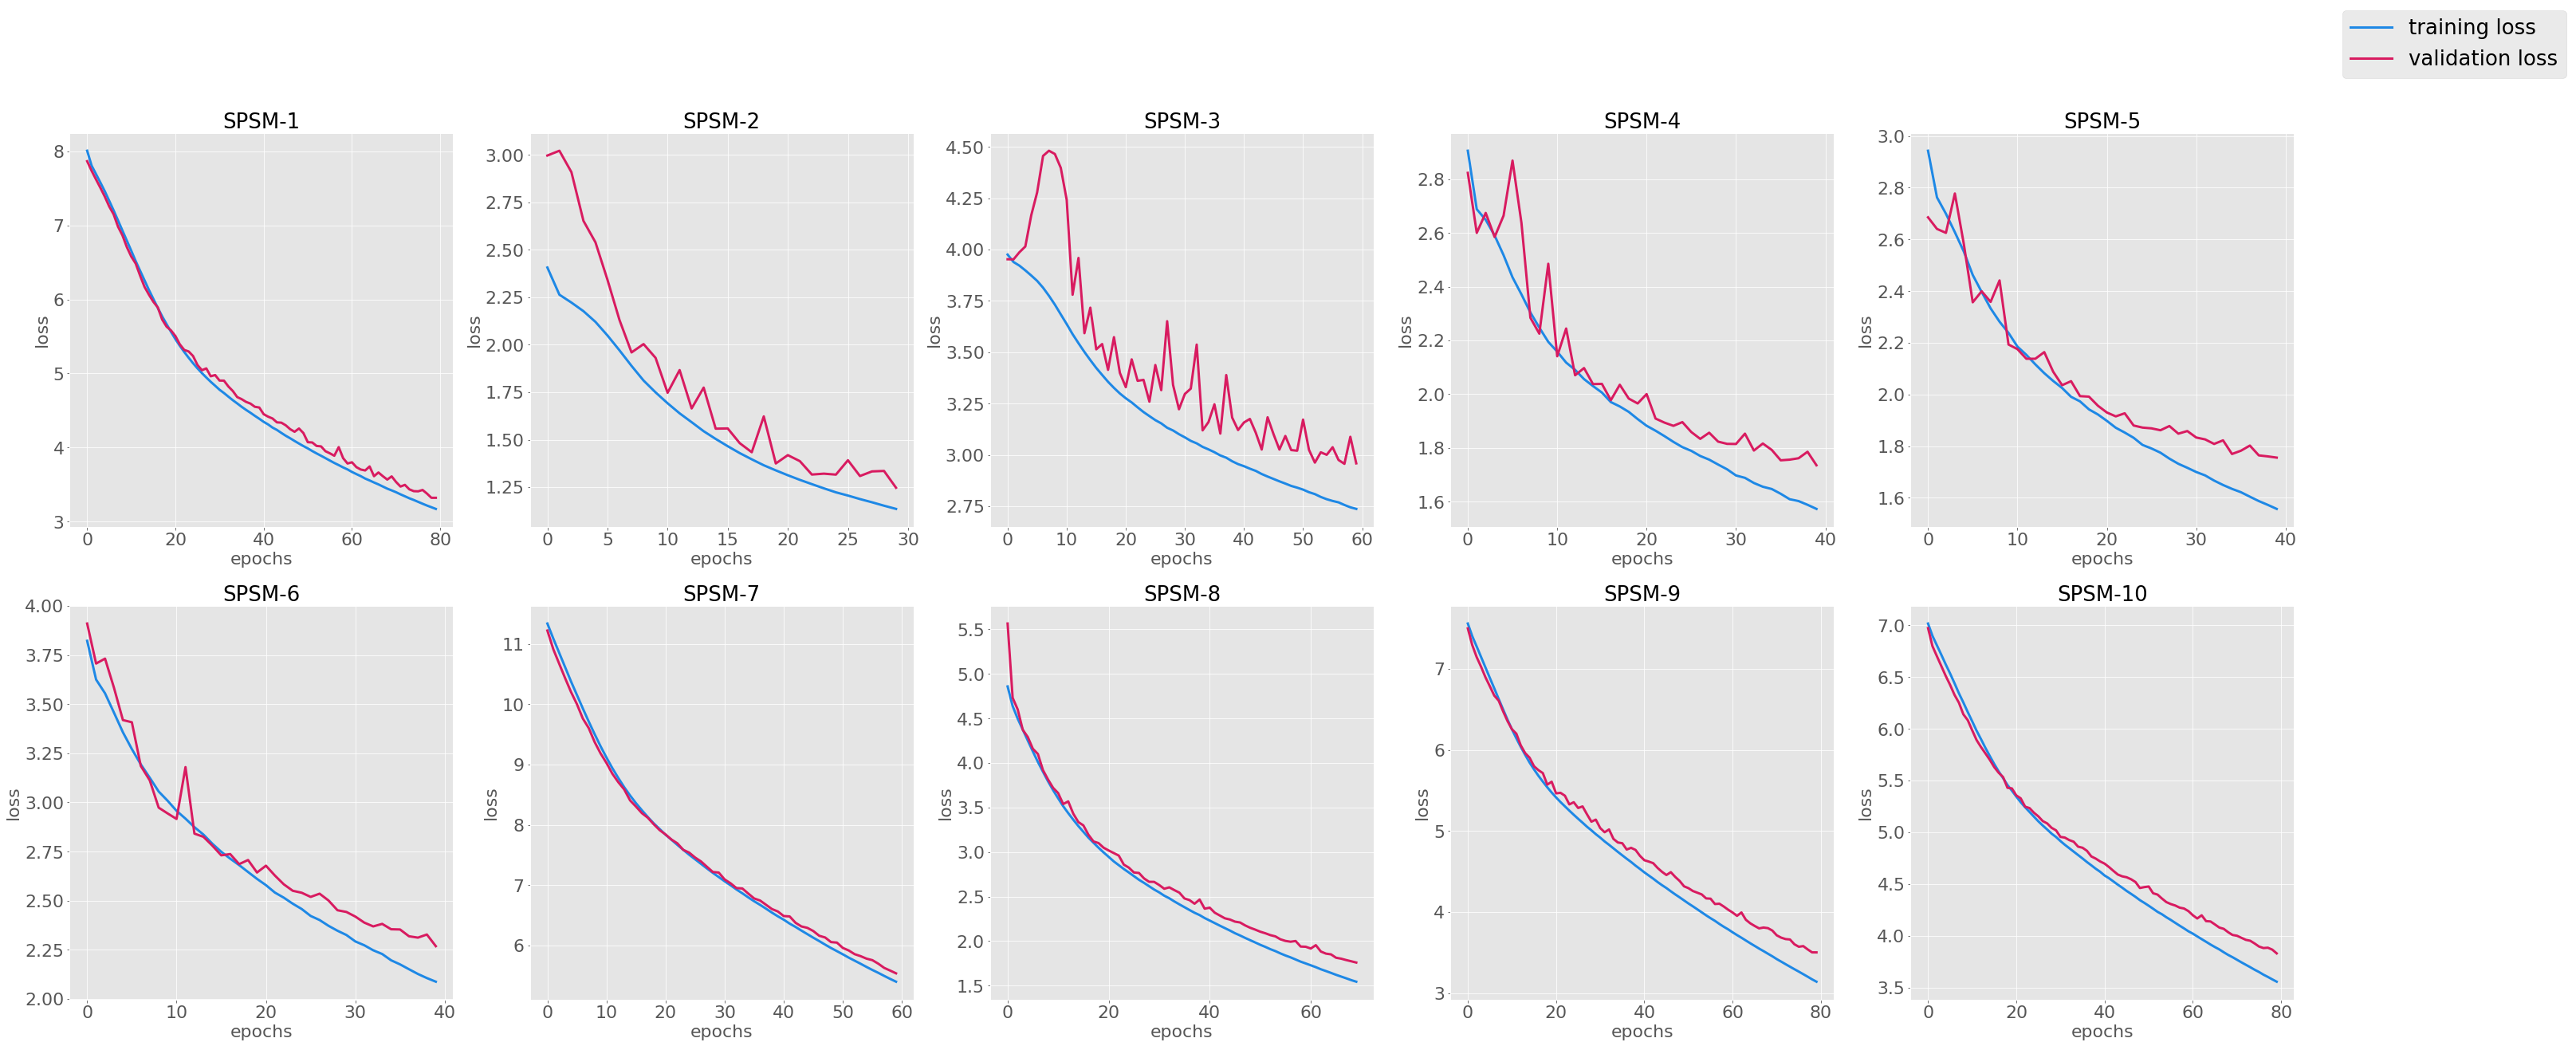

In [66]:
top_10_spsm = np.array(sorted(spsm_results, key=lambda k:k['best_val_accuracy']))[-10:]
model_ids_top_10 = [dict['model_name'].split('_')[-1] for dict in top_10_spsm]

tb_data_spsm = get_data_from_tb(model_ids_top_10, "TensorBoard/RT_50")

titles = ["SPSM-{}".format(i) for i in range(1, 11)]

fig = plot_loss_acc_curve(tb_data_spsm, 'loss', titles)
plt.show()

In [10]:
model_ids_top_10

['2e483',
 '59890',
 '46063',
 '07f05',
 'bbbc1',
 '905a2',
 'fa04f',
 '68e97',
 '402fb',
 'bf5a1']

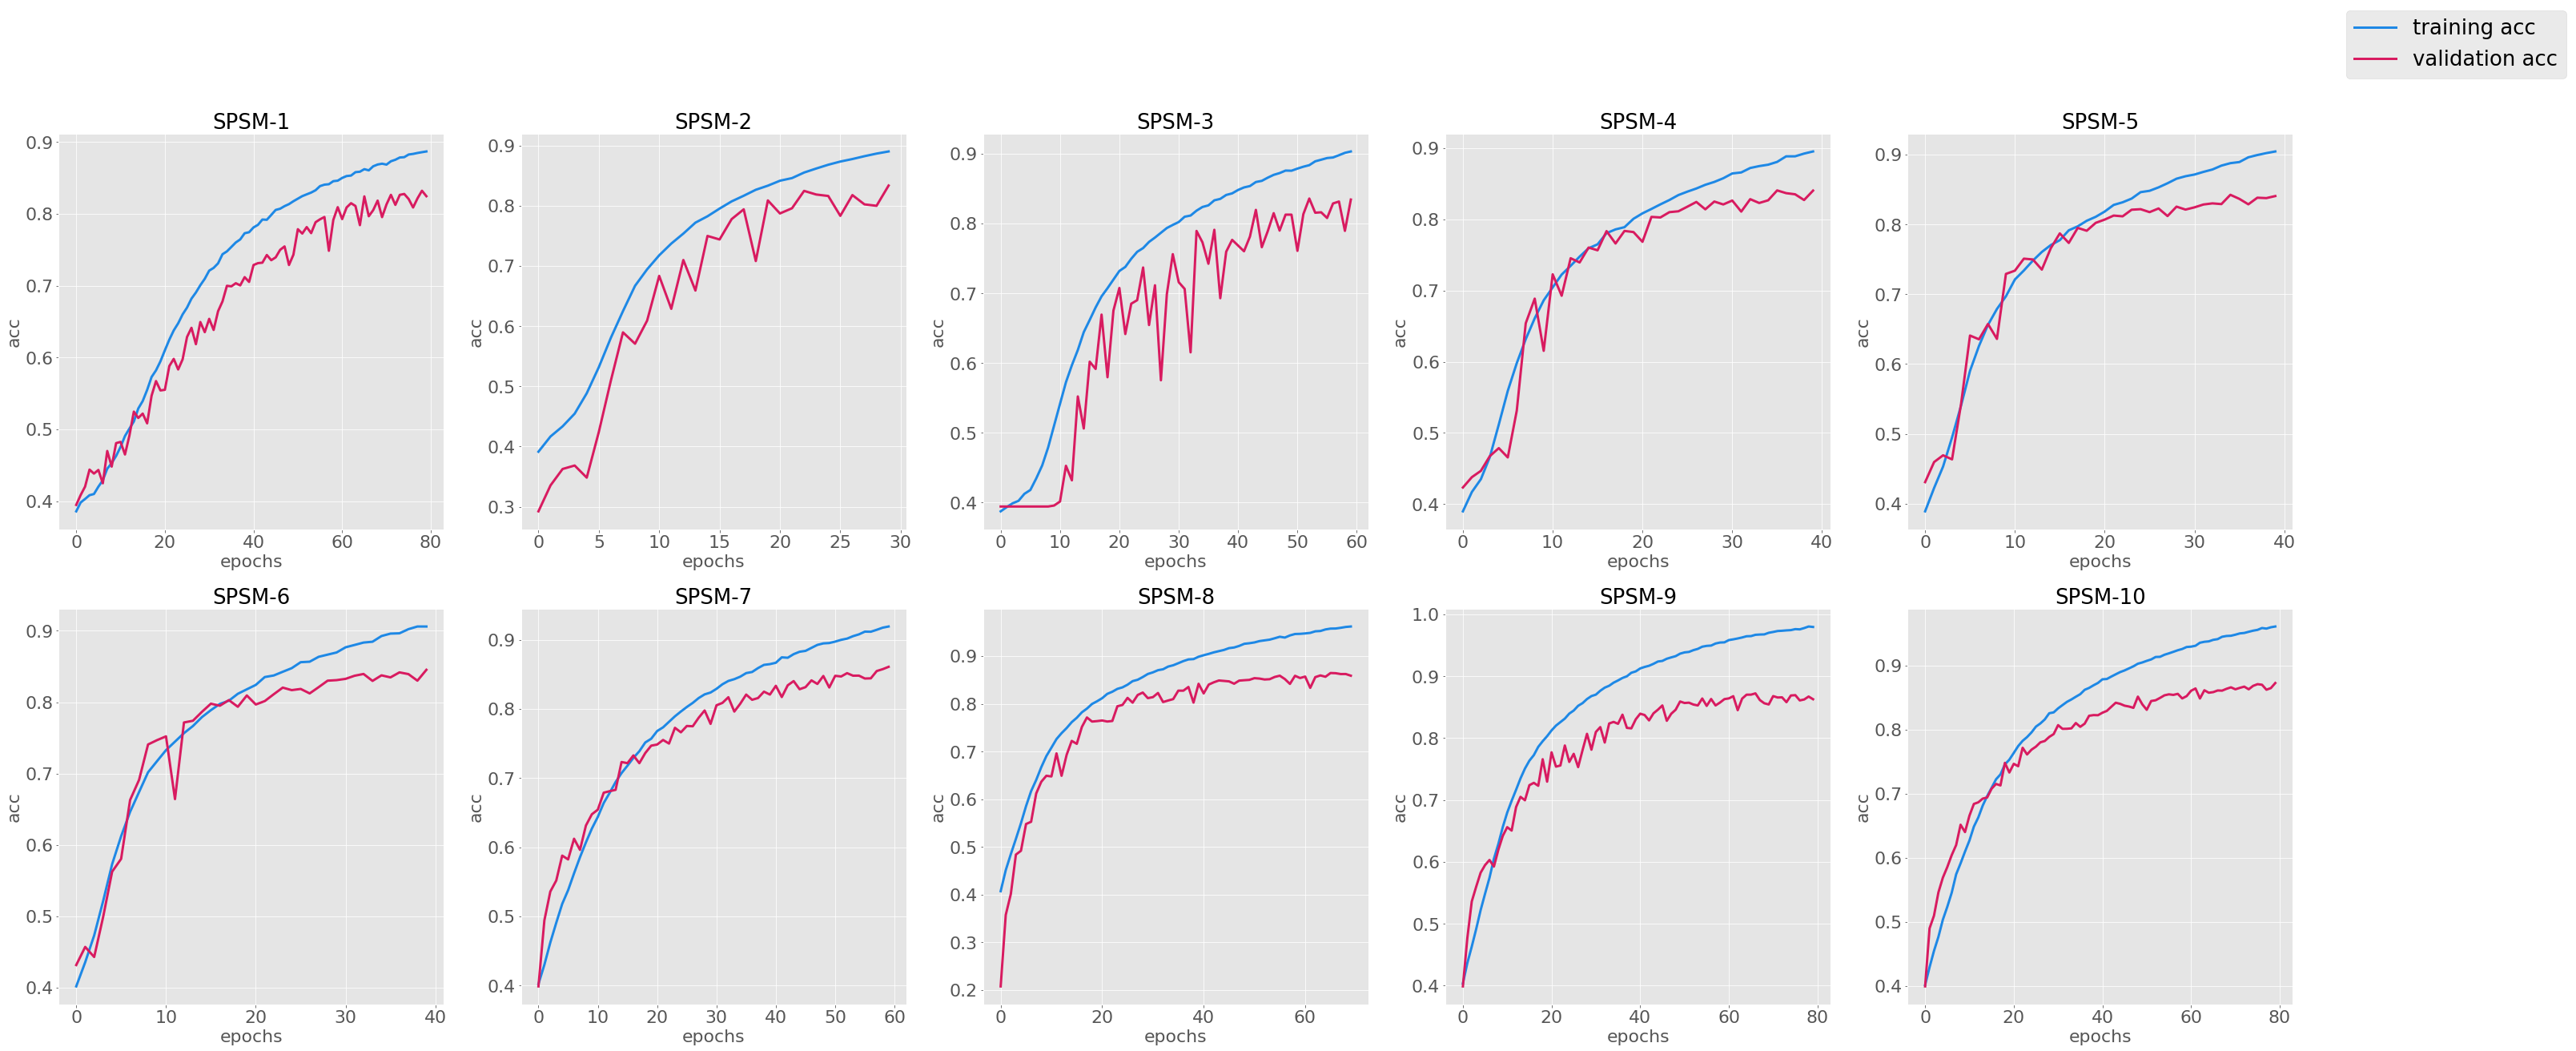

In [68]:
fig = plot_loss_acc_curve(tb_data_spsm, 'acc', titles)
plt.show()

In [135]:
model_srcs = [os.path.join("models", "{}.h5".format(model_id)) for model_id in model_ids_top_10]
model_dsts = [os.path.join("top_10_spsm", "SPSM-{}.h5".format(id + 1)) for id in range(len(model_ids_top_10))]
save_and_rename_models(model_srcs, model_dsts)

#### TM Parameters during TPE optimization

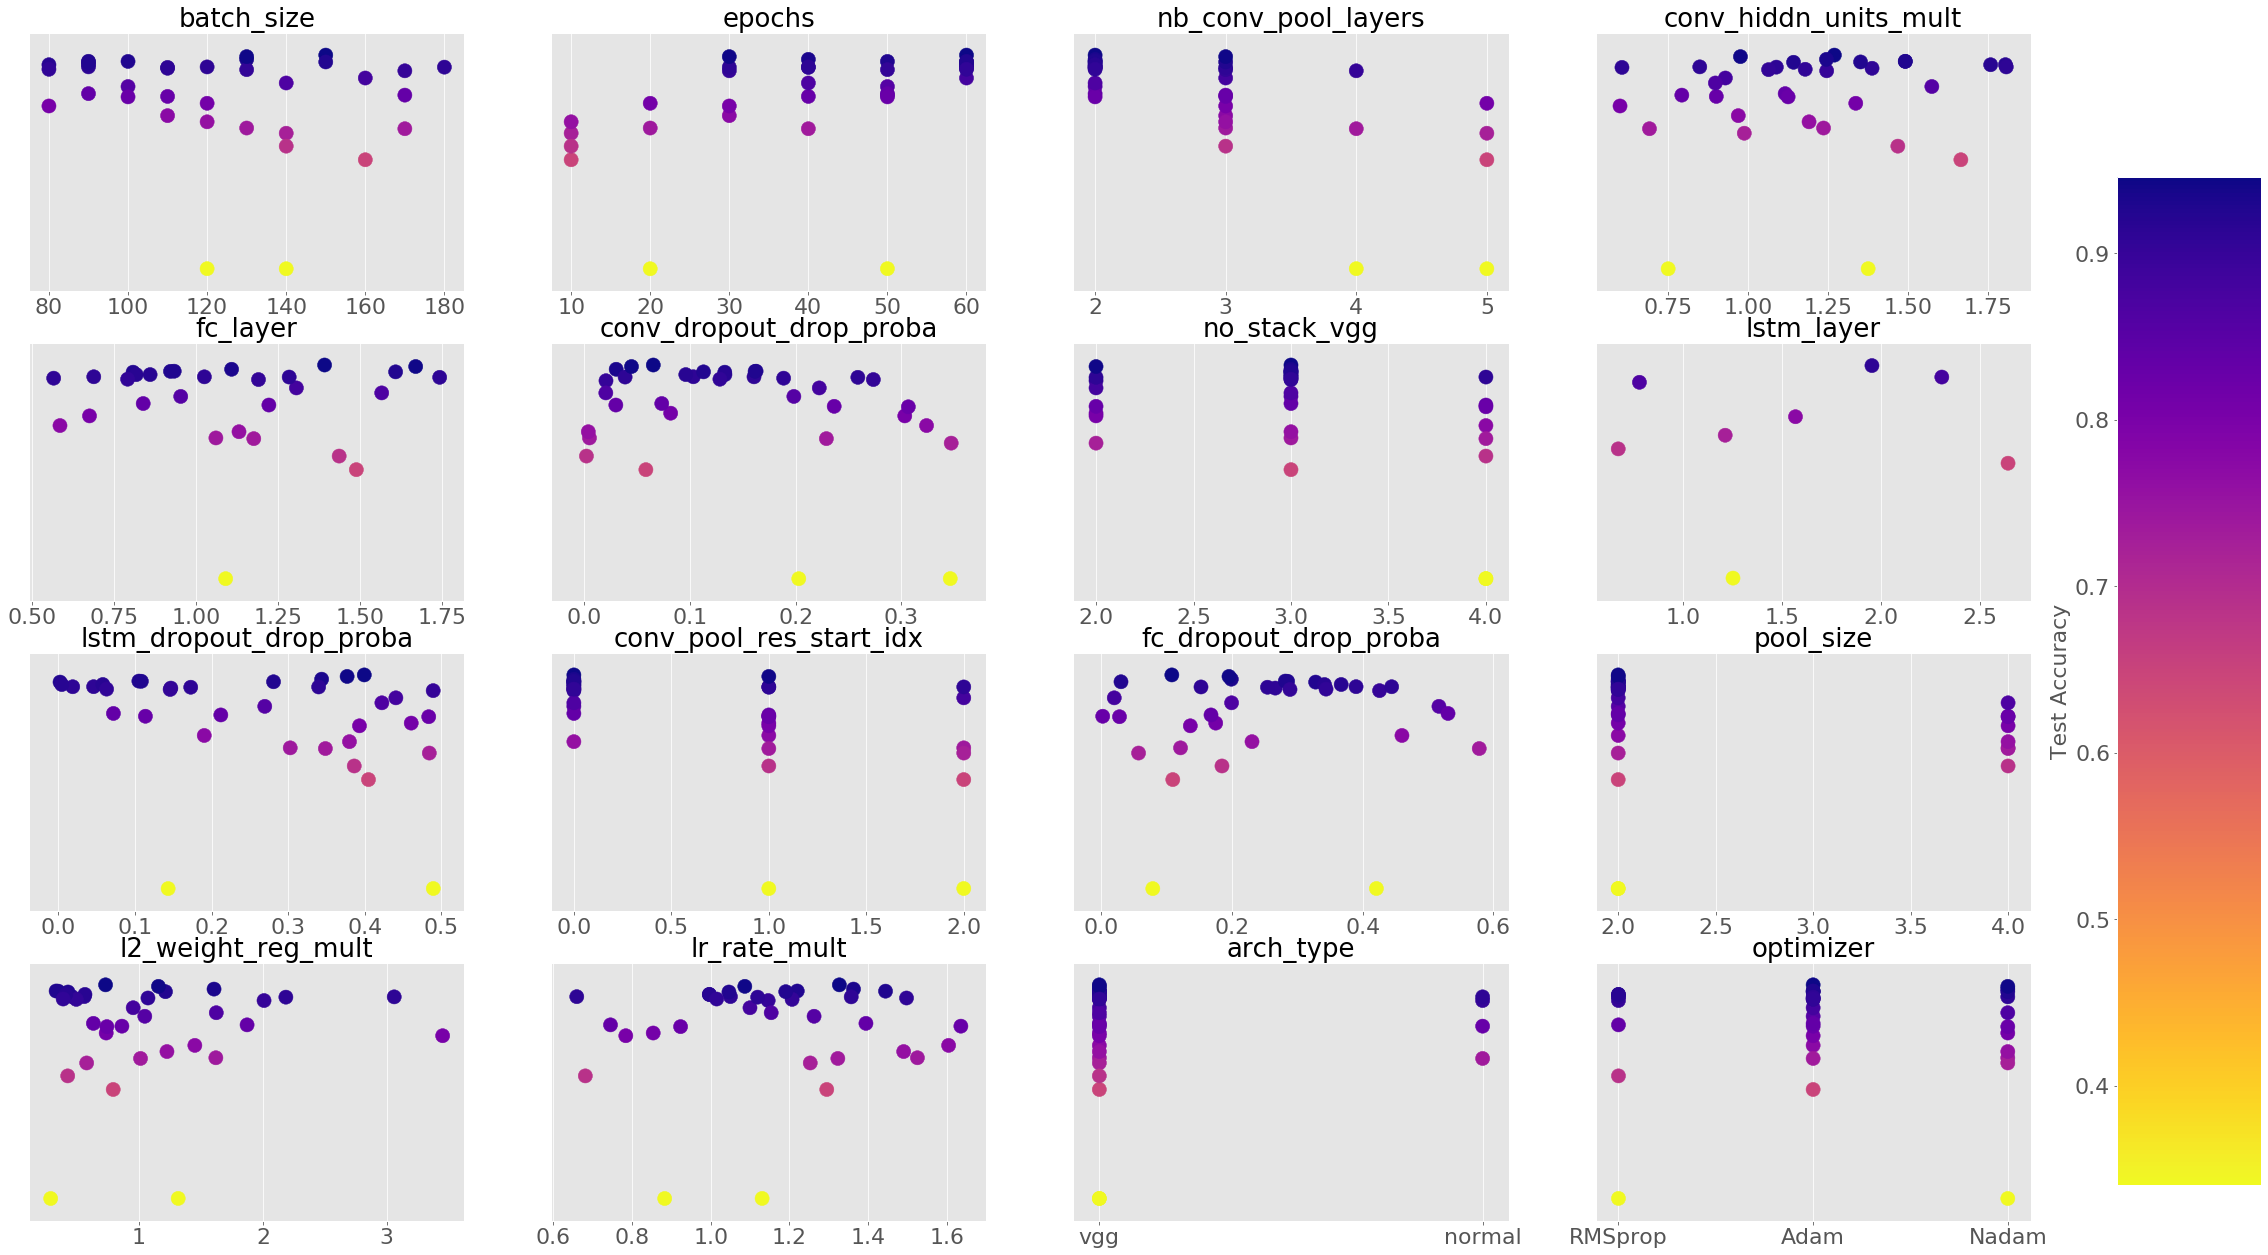

In [69]:
int_params_names_to_correlate = [
    'batch_size',
    'epochs',
    'nb_conv_pool_layers',
    'conv_hiddn_units_mult',
    'fc_layer',
    'conv_dropout_drop_proba',
    'no_stack_vgg',
    'lstm_layer',
    'lstm_dropout_drop_proba',
    'conv_pool_res_start_idx',
    'fc_dropout_drop_proba',
    'pool_size',
    'l2_weight_reg_mult',
    'lr_rate_mult',
    'arch_type',
    'optimizer'
]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(40,20))

axes = axes.flatten()
s = None
for ax, param in zip(axes, int_params_names_to_correlate):
    s = view_params_w_acc(param, tm_results, ax)
    
    
fig.subplots_adjust(right=0.82, top=0.95)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

cmap = mpl.cm.plasma_r
norm = mpl.colors.Normalize(vmin=tm_acc.min(), vmax=tm_acc.max())

cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical', ticklocation='left')
cb1.set_label('Test Accuracy', fontdict={'size': 22})

### Top 10 TMs based on val_accuracy

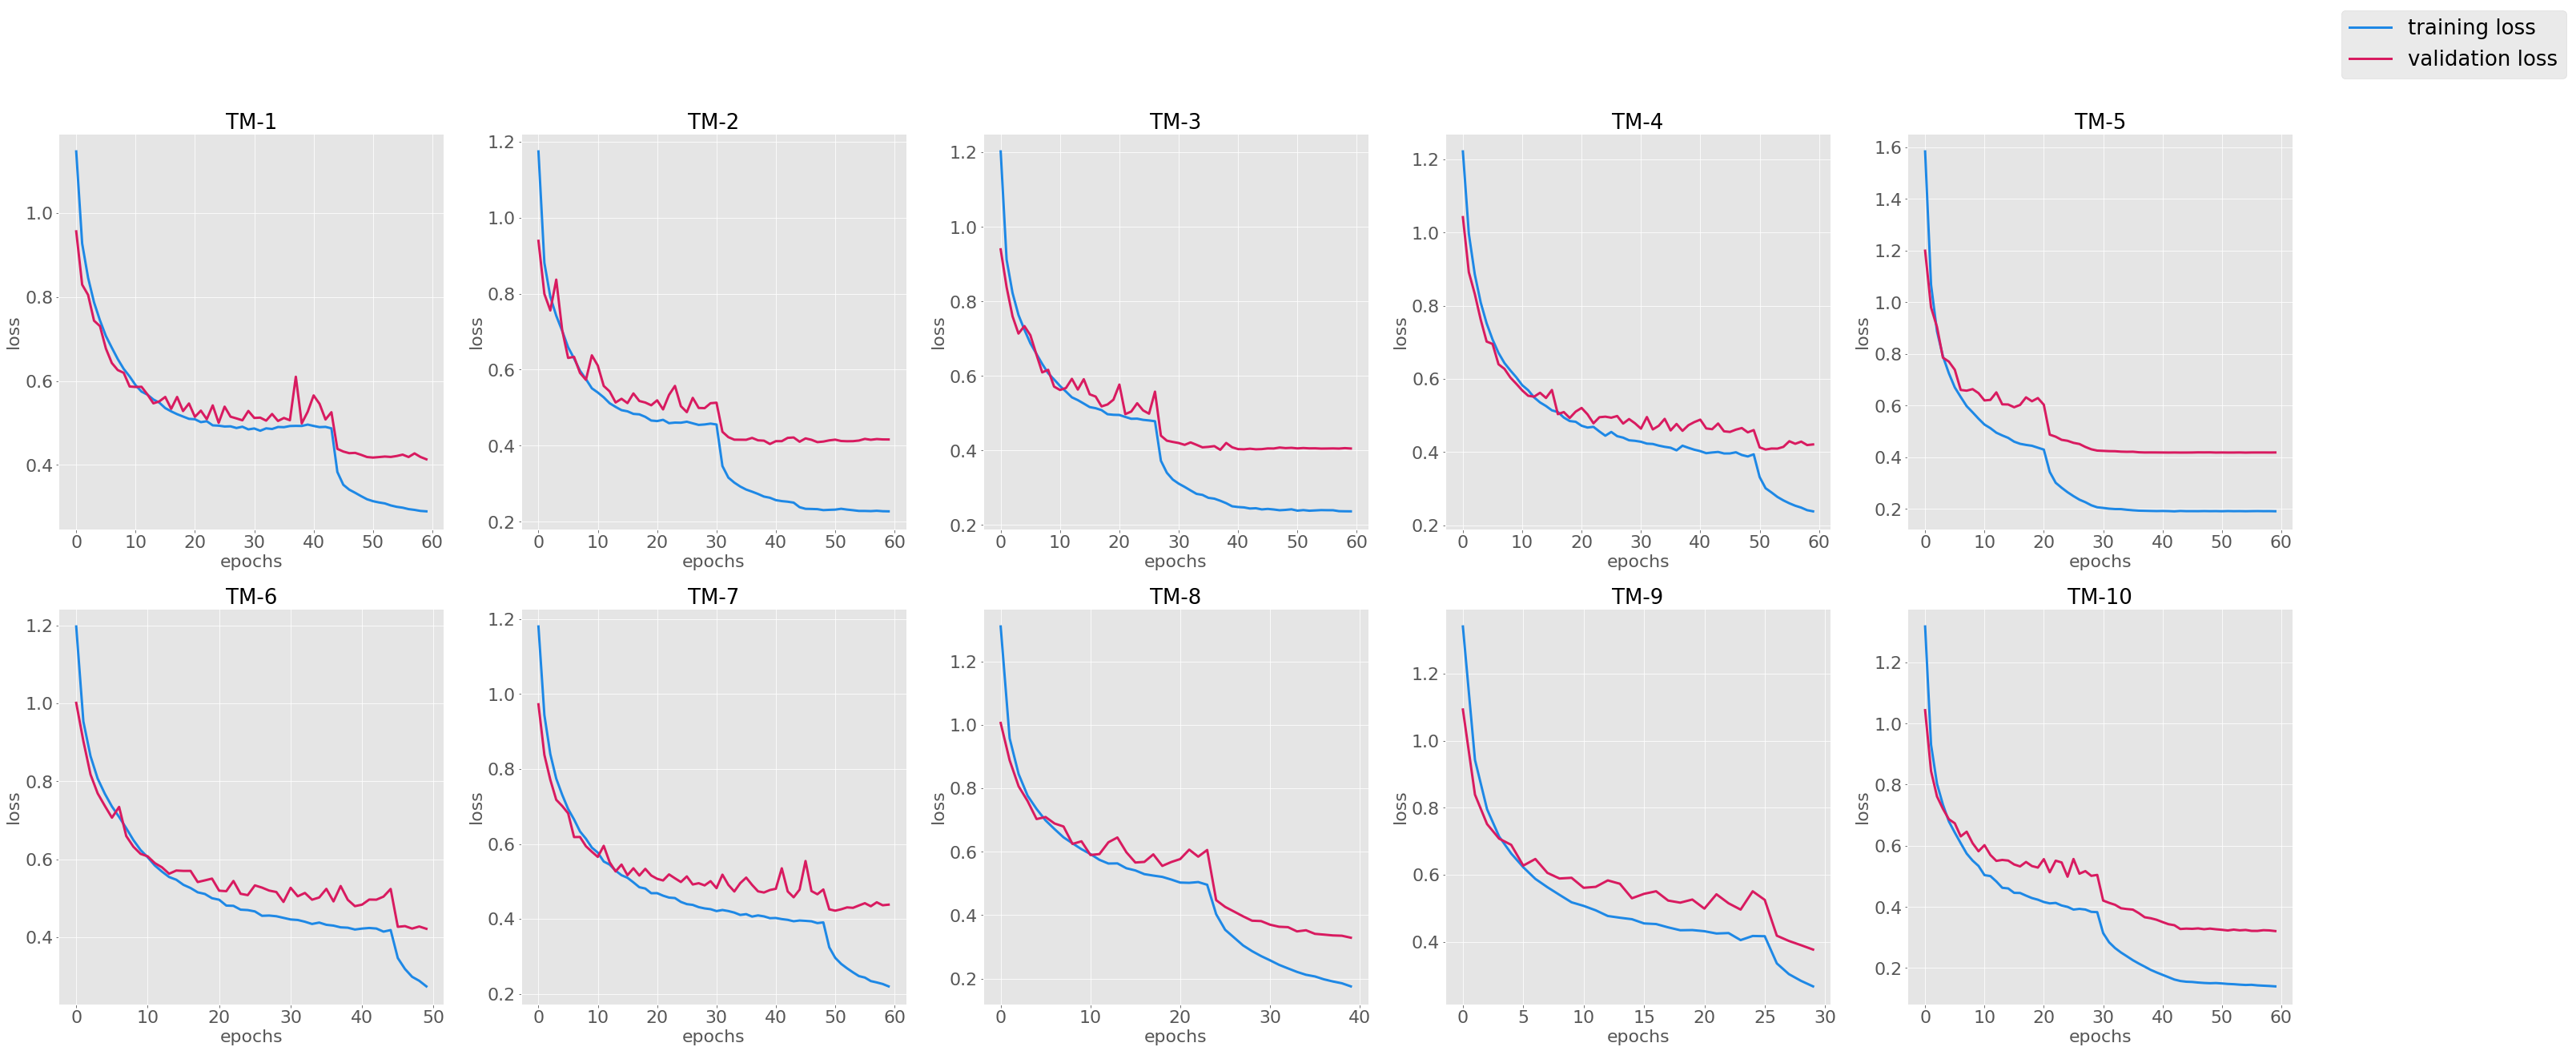

In [71]:
top_10_tm = np.array(sorted(tm_results, key=lambda k:k['best_val_accuracy']))[-10:]
model_ids_top_10 = [dict['model_name'].split('_')[-1] for dict in top_10_tm]

tb_data_tm = get_data_from_tb(model_ids_top_10, "TensorBoard/ERP_RT_10/")

titles = ["TM-{}".format(i) for i in range(1, 11)]

fig = plot_loss_acc_curve(tb_data_tm, 'loss', titles)
# fig.suptitle('Loss curves for top 10 TMs', fontsize=40)
plt.show()

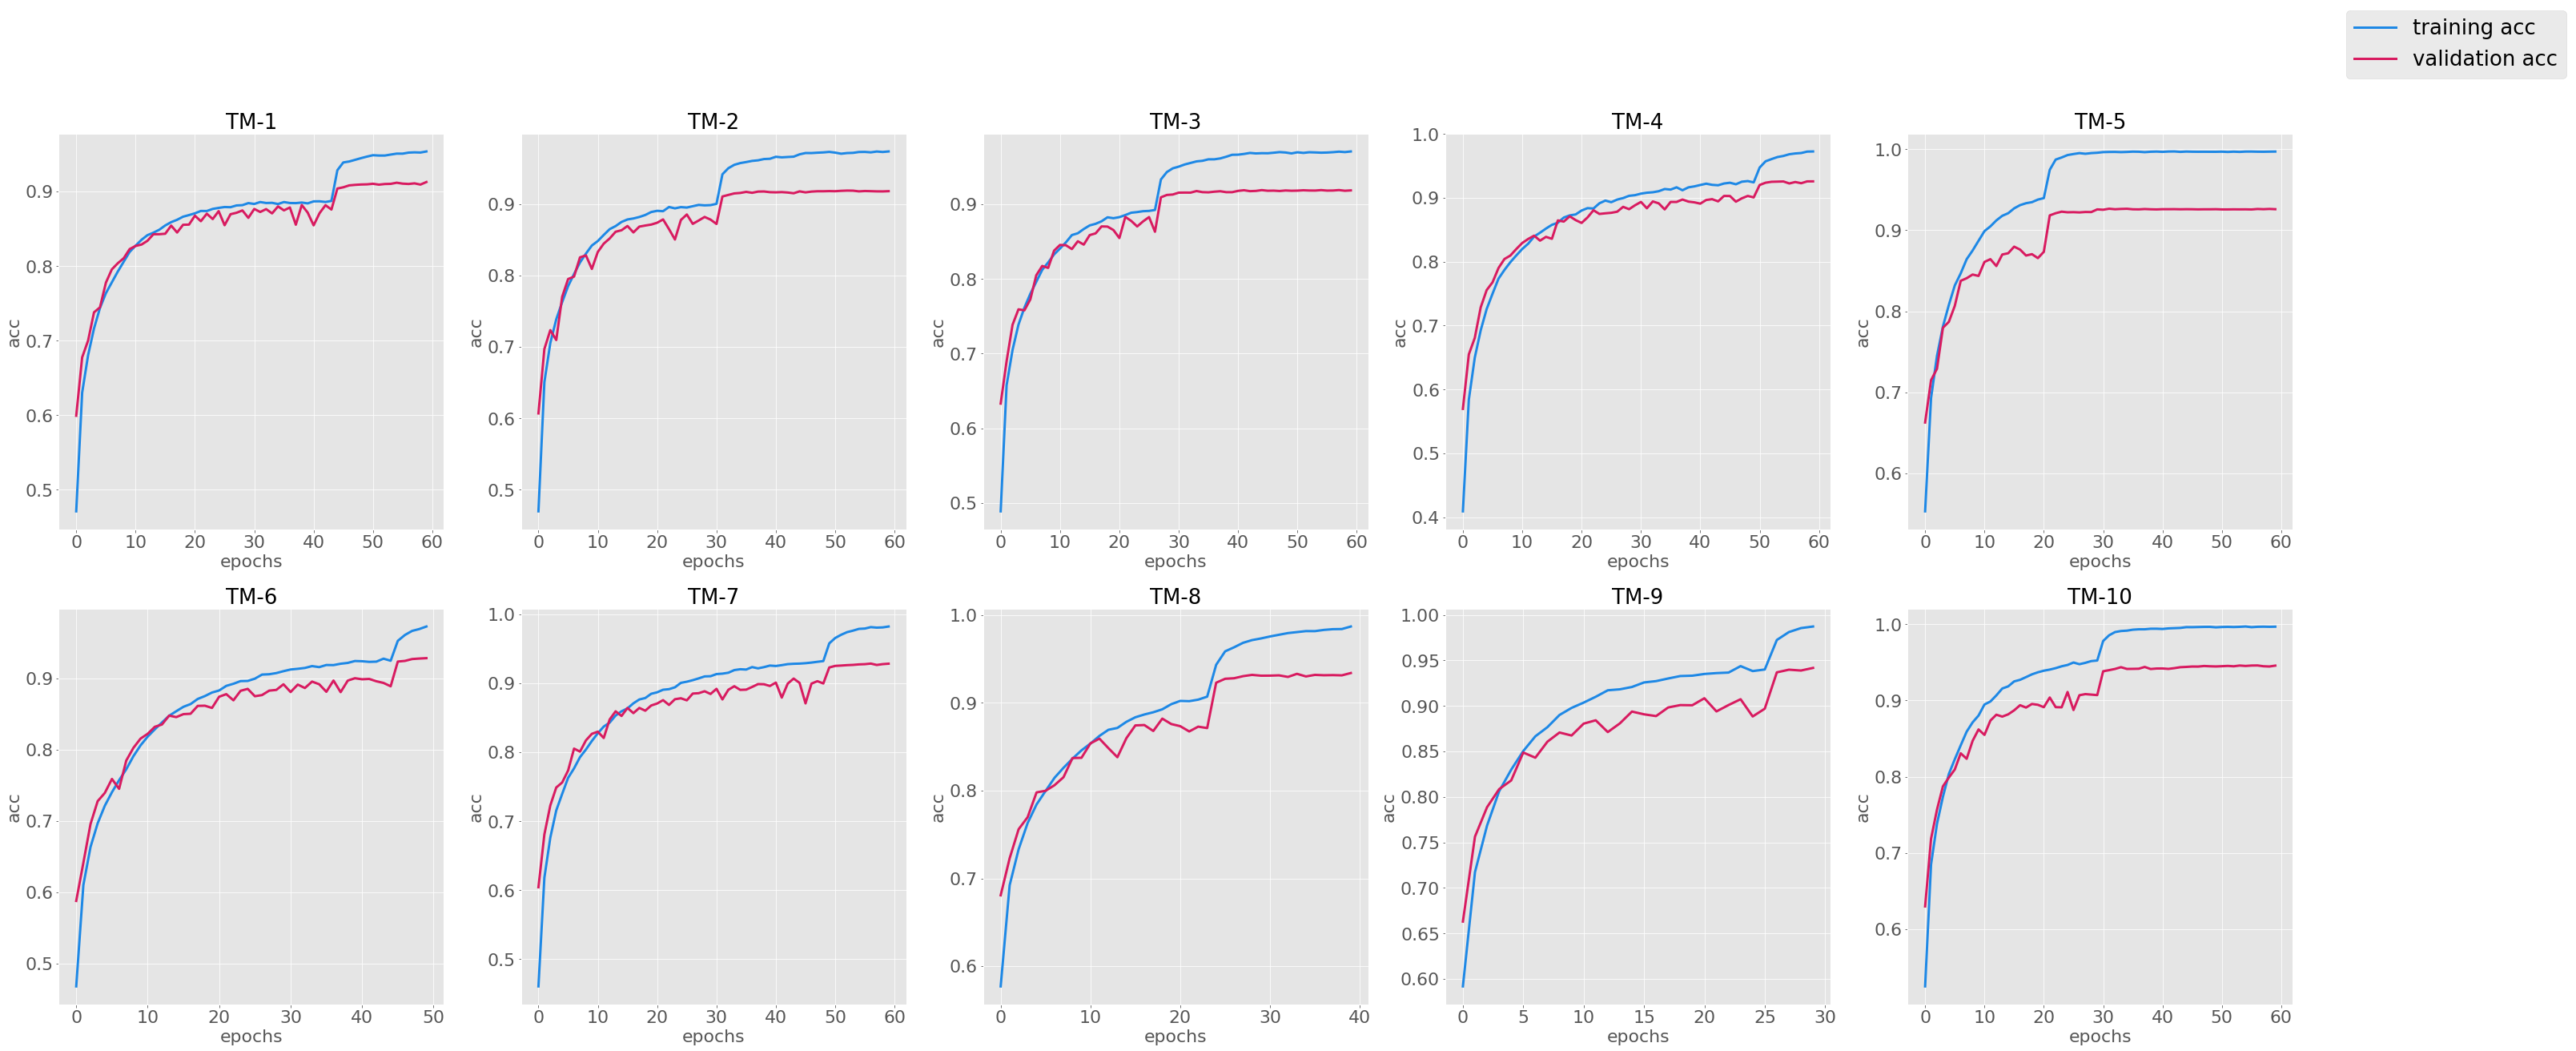

In [73]:
fig = plot_loss_acc_curve(tb_data_tm, 'acc', titles)
plt.show()

In [140]:
model_srcs = [os.path.join("models/ERP_RT_10", "{}.h5".format(model_id)) for model_id in model_ids_top_10]
model_dsts = [os.path.join("top_10_tm", "TM-{}.h5".format(id + 1)) for id in range(len(model_ids_top_10))]
save_and_rename_models(model_srcs, model_dsts)